In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from esn.esn import DeepESN, DeepSubreservoirESN
from esn import activation as A
from esn.initialization import *
from scipy.integrate import odeint
import torch
np.random.seed(42)

In [2]:
from sklearn.metrics import mean_squared_error

In [3]:
device = torch.device('cpu')
dtype = torch.double
torch.set_default_dtype(dtype)

In [4]:
pat_2 = pd.read_csv('data/abc_pat_2.csv')
pat_8 = pd.read_csv('data/abc_pat_8.csv')
pat_17 = pd.read_csv('data/abc_pat_17.csv')

In [5]:
pat_2

,Unnamed: 0,t,mtd,C,P,Q,Qp
0,0,-11.107011,43.373173,0.000000,37.275418,6.097756,0.000000
1,1,-11.007011,44.271460,0.000000,37.775400,6.496060,0.000000
2,2,-10.907011,45.177516,0.000000,38.277831,6.899685,0.000000
3,3,-10.807011,46.091249,0.000000,38.782594,7.308655,0.000000
4,4,-10.707011,47.012562,0.000000,39.289567,7.722995,0.000000
...,...,...,...,...,...,...,...
495,495,38.400000,87.944837,0.005428,31.502929,56.270500,0.171409
496,496,38.500000,88.502969,0.005355,31.732567,56.600418,0.169984
497,497,38.600000,89.063316,0.005283,31.961926,56.932816,0.168574
498,498,38.700000,89.625832,0.005211,32.190963,57.267690,0.167179


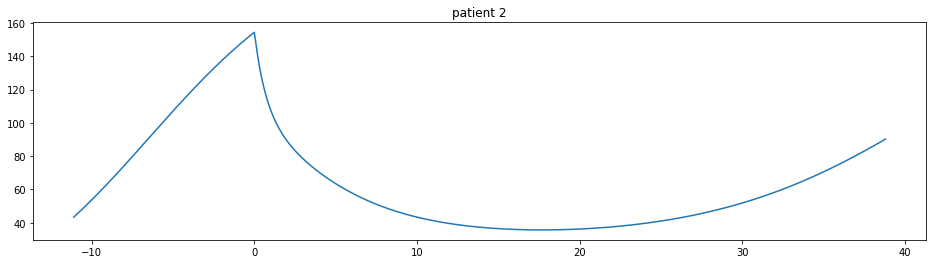

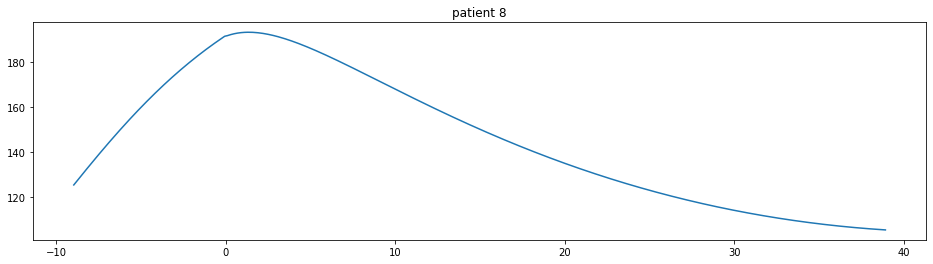

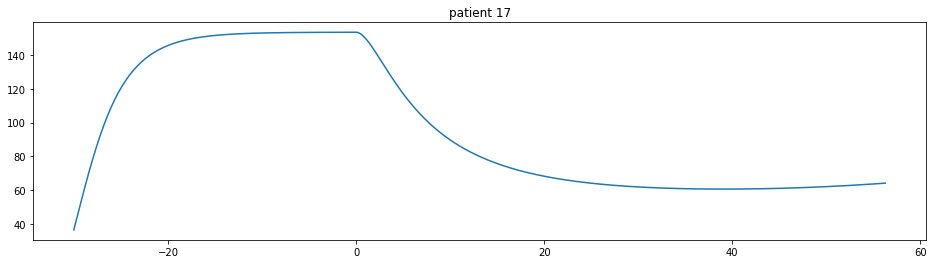

In [6]:
for pat, title in [(pat_2, 'patient 2'), (pat_8, 'patient 8'), (pat_17, 'patient 17')]:
    fig = plt.figure(figsize=(16,4))
    ax = fig.gca()
    ax.set_title(title)
    ax.plot(pat.t, pat.mtd)
    plt.show()

In [7]:
def data_for_patient(pat, start_train=0, div=0.7):
    data = pat[(pat.t >= start_train)]['mtd'].to_numpy()
    trainingLength = int(len(data) * div)
    print(data[:-1].shape)
    X = data[:-1].reshape((-1, 1, 1))
    print(X.shape)
    X = torch.from_numpy(X).to(device)
    y = data[1:].reshape((-1, 1, 1))
    y = torch.from_numpy(y).to(device)
    return X[:-trainingLength], X[-trainingLength:], y[:-trainingLength], y[-trainingLength:]

In [8]:
def experiment(pat, start_train=0, transient=100, hidden_size=100):
    X, X_test, y, y_test = data_for_patient(pat, start_train)
    print(X.shape, y.shape)
    print(X_test.shape, y_test.shape)
    t_test = pat[pat.t >= start_train].iloc[len(y) + 1:].t
    esn = DeepESN(1, hidden_size, initializer=WeightInitializer(), num_layers=3, bias=False,
                  activation=A.relu(leaky_rate=0.5), transient=transient)
    esn.fit(X, y)
    pred = []
    p = y[-1:]
    n = len(X_test)# // 2
    for i in range(n):
        p = esn(p)
        p = torch.reshape(p, (1,1,1))
        pred.append(p.item())
    y_pred = pred
    fig = plt.figure(figsize=(16,4))
    ax = fig.gca()
    ax.plot(pat.t, pat.mtd, label='test')
    ax.plot(t_test[:n], y_pred, label='prediction')
    ax.axvline(x=start_train, ymin=0, ymax=1, color='r')
    plt.show()

In [9]:
def data_for_patient_low_data(pat, start_train=0, div=0.5):
    data = pat[(pat.t >= start_train)]['mtd'].to_numpy()
    trainingLength = int(len(data) * div)
#     print(data[:-1].shape)
    X = data[:-1].reshape((-1, 1, 1))
#     print(X.shape)
    X = torch.from_numpy(X).to(device)
    y = data[1:].reshape((-1, 1, 1))
    y = torch.from_numpy(y).to(device)
    return X[:-trainingLength:10], X[-trainingLength::10], y[:-trainingLength:10], y[-trainingLength::10]

In [114]:
def experiment_low_data(pat, start_train=0, transient=100, hidden_size=100):
    X, X_test, y, y_test = data_for_patient_low_data(pat, start_train)
#     print(X.shape, y.shape)
#     t_test = pat[pat.t >= start_train].iloc[len(y) + 1:].t
    t_test = pat[pat.t >= start_train][::10].iloc[len(y):].t
    t_measurement = pat[pat.t >= start_train][::10].iloc[:len(y)].t
#     t_test = t_test[::10]
#     print(pat[pat.t >= start_train].t[::10])
#     print(t_test)
#     print(t_test[::10])
#     print(X_test.shape, t_test.shape)
#     esn = DeepESN(1, hidden_size, initializer=WeightInitializer(), num_layers=3, bias=False,
#                   activation=A.relu(leaky_rate=0.4), transient=transient)
    esn = DeepSubreservoirESN(1,1, initializer=SubreservoirWeightInitializer(subreservoir_size=100),
                              num_layers=2, bias=False, activation=A.relu(leaky_rate=0.4),
                              transient=10)
    esn.fit(X, y)
    pred = []
    p = y[-1:]
    n = len(X_test)# // 2
    for i in range(n):
        p = esn(p)
        p = torch.reshape(p, (1,1,1))
        pred.append(p.item())
    y_pred = pred
    fig = plt.figure(figsize=(16,4))
    ax = fig.gca()
    ax.plot(pat.t, pat.mtd, label='test')
    ax.plot(t_measurement, X.numpy().reshape((31,)), '.', color='red')
    ax.plot(t_test, y_pred[:], label='prediction')
    ax.axvline(x=start_train, ymin=0, ymax=1, color='r')
    print(len(y_pred), X_test.shape)
    plt.show()

31 torch.Size([31, 1, 1])


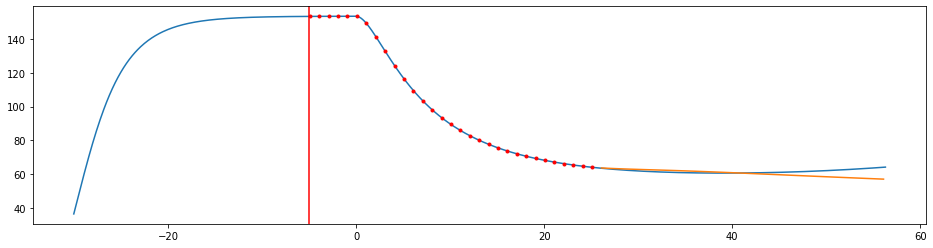

In [120]:
%matplotlib inline
experiment_low_data(pat_17, -5, hidden_size=30, transient=10)

In [135]:
for size in np.arange(10, 200, 10):
    pat = pat_8
#     size = 100
    start_train = 0
    transient = 10
    layers = 2
    leaky = 0.4
    X, X_test, y, y_test = data_for_patient_low_data(pat, start_train)
    #     t_test = pat[pat.t >= start_train].iloc[len(y) + 1:].t
    t_test = pat[pat.t >= start_train][::10].iloc[len(y):].t
    t_measurement = pat[pat.t >= start_train][::10].iloc[:len(y)].t
    #     t_test = t_test[::10]
    #     print(pat[pat.t >= start_train].t[::10])
    #     print(t_test)
    #     print(t_test[::10])
    #     print(X_test.shape, t_test.shape)
#     esn = DeepESN(1, size, initializer=WeightInitializer(), num_layers=layers, bias=False,
#                   activation=A.relu(leaky_rate=leaky), transient=transient)
    esn = DeepSubreservoirESN(1,1, initializer=SubreservoirWeightInitializer(subreservoir_size=size),
                              num_layers=layers, bias=False, activation=A.relu(leaky_rate=leaky),
                              transient=transient)
    esn.fit(X, y)
    pred = []
    p = y[-1:]
    n = len(X_test)# // 2
    for i in range(n):
        p = esn(p)
        p = torch.reshape(p, (1,1,1))
        pred.append(p.item())
    y_pred = pred
    print(size, mean_squared_error(y_test.view(-1).detach().numpy(), pred))
#     fig = plt.figure(figsize=(16,4))
#     ax = fig.gca()
#     ax.plot(pat.t, pat.mtd, label='test')
#     ax.plot(t_measurement, X.numpy().reshape((20,)), '.', color='red')
#     ax.plot(t_test[:len(y_pred)], y_pred[:-1], label='prediction')
#     ax.axvline(x=start_train, ymin=0, ymax=1, color='r')
#     print(len(y_pred), X_test.shape)
#     plt.show()

10 13.838609309539384
20 2.6126781745631176
30 4.008815064390955
40 3.364022781325429
50 3.76989764887377
60 5.72528610282353
70 5.922194770230171
80 3.597561529331512
90 2.5363450186622267
100 3.096902892286007
110 3.518172576885873
120 2.3989630026612843
130 3.067305598631464
140 3.2476066158169155
150 2.6366567555372304
160 2.404587214629174
170 2.611257959664346
180 3.313396349495148
190 3.3102768939289247


In [8]:
X, X_test, y, y_test = data_for_patient(pat_2, 0)
t_test = pat[pat.t >= 0].iloc[len(y) + 1:].t

(387,)
(387, 1, 1)


In [9]:
for size in np.arange(50, 1100, 50):
    transient = 100
#     size = 100
    esn = DeepESN(1, size, initializer=WeightInitializer(), num_layers=3, bias=False,
                  activation=A.relu(leaky_rate=0.5), transient=transient)
    esn.fit(X, y)
    pred = []
    p = y[-1:]
    n = len(X_test) // 2
    for i in range(n):
        p = esn(p)
        p = torch.reshape(p, (1,1,1))
        pred.append(p.item())
    y_test_ = y_test[:len(pred)]
    print(size, mean_squared_error(y_test_.view(-1).detach().numpy(), pred))    

50 61.862757206744504
100 9.441848079021938
150 5.925284147499561
200 1.64190026604303
250 1.6227570661599358
300 0.6214029211662192
350 5.836682001084479
400 3.086694805379487
450 2.631836678030685
500 1.3214168300117235
550 1.4676080331955532
600 1.0710209560731656
650 3.7085829167776834
700 1.7394270179158788
750 1.474194148454141
800 3.194526340705546
850 0.9152547204252887
900 2.4468913439901923
950 1.433501999280591
1000 2.6109043403216208
1050 1.3573380826195267


(387,)
(387, 1, 1)
torch.Size([116, 1, 1]) torch.Size([116, 1, 1])
torch.Size([271, 1, 1]) torch.Size([271, 1, 1])


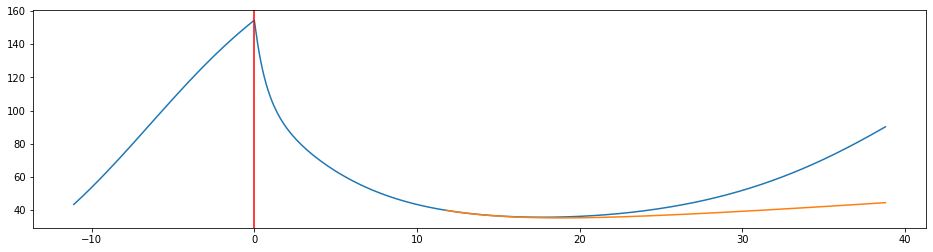

In [21]:
experiment(pat_2, 0, hidden_size=150)

(388,)
(388, 1, 1)
torch.Size([116, 1, 1]) torch.Size([116, 1, 1])


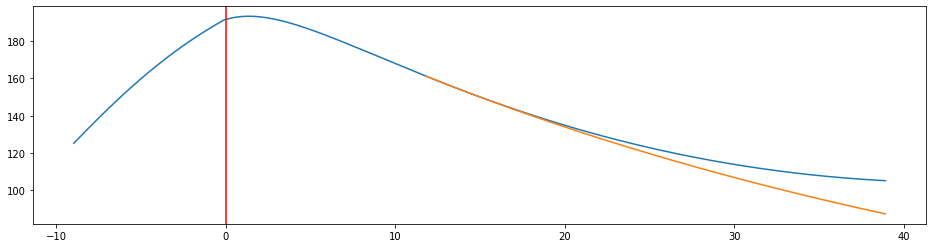

In [11]:
experiment(pat_8, 0)

(562,)
(562, 1, 1)
torch.Size([168, 1, 1]) torch.Size([168, 1, 1])


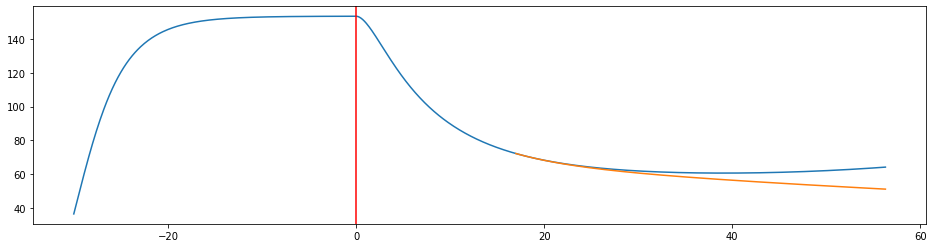

In [12]:
experiment(pat_17, 0)